In [5]:
import sys
sys.path.append('../')

In [6]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from mygp.gp import GP
import mygp.kernel as kernels  

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
# Generate data
train_x = np.array([-4.1, -1.3, 0.0, 2.1, 3.3, 4.5]).reshape(-1, 1)
train_y  = np.sin(train_x)
X_s = np.linspace(-5, 5, 100).reshape(-1, 1)

# GP with squared exponential kernel
sin_GP = GP(X_s=X_s, train_x=train_x, train_y=train_y, kernel=kernels.rbf)

(100,) (100, 100)


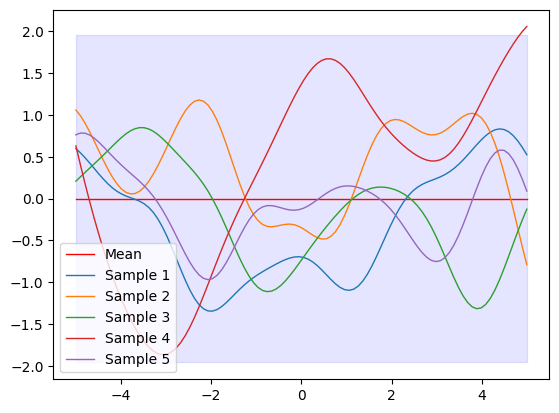

In [43]:
# Generate samples and print out the prior distribution
samples = np.random.multivariate_normal(sin_GP.mu.ravel(), sin_GP.cov, 5)
print(sin_GP.mu.shape, sin_GP.cov.shape)
sin_GP.plot(samples=samples)

NLL:  [[-6.89159434]]


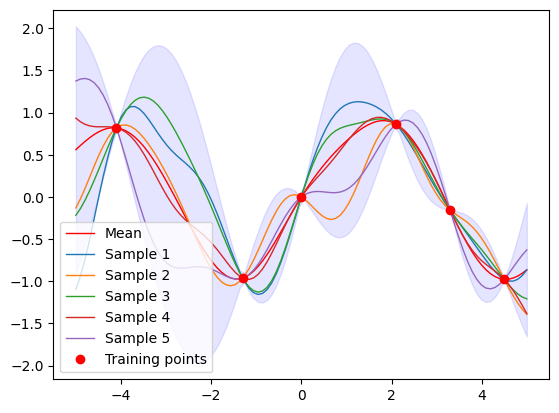

In [44]:
# Make predictions, and plot the posterior distribution
_, _, nll = sin_GP.predict(sin_GP.X_s)
print("NLL: ", nll.squeeze())
post_samples = np.random.multivariate_normal(sin_GP.mu.ravel(), sin_GP.cov, 5)
sin_GP.plot(train_x=train_x, train_y=train_y, samples=post_samples)